In [35]:
import keras
import tensorflow as tf
import random
import os
import numpy as np
from PIL import Image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# set log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
class CustomDataGen(keras.utils.Sequence):
    def __init__(self, data_folder: str, aug_len: dict[str, float], batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=10, split="train", train_ratio=0.8, seed=42):
        super().__init__(workers, use_multiprocessing, max_queue_size)

        self.data_folder = data_folder
        self.aug_len = aug_len
        self.batch_size = batch_size
        self.data = []

        self.pipeline = tf.keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.01),
            keras.layers.Rescaling(1./255),
            keras.layers.Resizing(224, 224),
            keras.layers.Normalization(
                mean=(0.485, 0.456, 0.406), 
                variance=(0.229, 0.224, 0.225)
            )
        ])

        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.load_data()
        self.classes = {label: idx for idx, label in enumerate(set([item["label"] for item in self.data]))}

    
    def load_data(self):

        all_files = []
        for root, _, files in os.walk(self.data_folder):
            ext = os.path.splitext(files[0])[1]
            if ext not in [".jpg", ".jpeg", ".png"]:
                continue
            subfolder = os.path.basename(root)
            for file in files:
                all_files.append({
                    "path": os.path.join(root, file),
                    "label": subfolder
                })

        random.seed(self.seed)
        random.shuffle(all_files)
        

        split_idx = int(len(all_files) * self.train_ratio)
        

        if self.split == "train":
            base_files = all_files[:split_idx]
        else:
            base_files = all_files[split_idx:]
        

        self.data = []
        for file in base_files:
            if self.split == "train" and file["label"] in self.aug_len:
                prob = self.aug_len[file["label"]]
                for _ in range(int(prob)):
                    self.data.append(file)
                if np.random.rand() < (prob - int(prob)):
                    self.data.append(file)
            else:
                self.data.append(file)
        
        random.shuffle(self.data)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for item in batch_data:
            img = Image.open(item["path"])
            img = np.array(img)
            if img.ndim == 2:
                img = np.stack((img,) * 3, axis=-1)
            elif img.shape[2] == 1:
                img = np.concatenate([img] * 3, axis=-1)
            img = self.pipeline(img)
            batch_images.append(img)
            batch_labels.append(self.classes[item["label"]])

        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.load_data()
        random.shuffle(self.data)
        


In [138]:
train = CustomDataGen("/home/shared/Mammiferes_test", {"cat": 0.5, "dog": 0.5}, batch_size=32, split="train")
val = CustomDataGen("/home/shared/Mammiferes_test", {}, batch_size=32, split="val")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99822813..1.2230139].


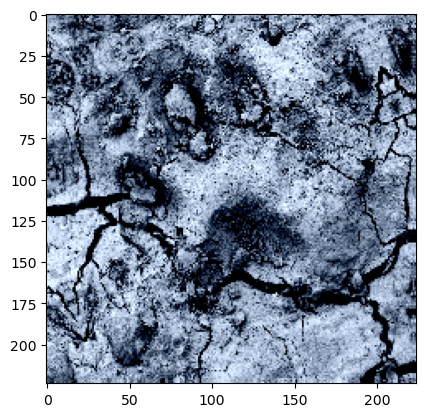

In [139]:
import matplotlib.pyplot as plt
import cv2
image_path = "/home/shared/Mammiferes_test/Chat/Chat_06.jpg"

img = cv2.imread(image_path)
img2 = train.pipeline(img)


plt.imshow(img2)

In [140]:
model2 = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1000,
    classifier_activation="softmax",
    include_top=False
)

In [141]:
model_custom_softmax = keras.Sequential([
    model2,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(10, activation="softmax")
])

model_custom_softmax.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
)


In [142]:
save_best = keras.callbacks.ModelCheckpoint("model.weights.keras", save_best_only=True, save_weights_only=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)

In [143]:
model3 = keras.Sequential([
    #cnn
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
model3.compile( optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy())
model3.fit(train, validation_data=val, epochs=10, callbacks=[save_best, reduce_lr], batch_size=32)

Epoch 1/10
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: nan

2024-12-02 18:04:56.502809: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: ValueError: Exception encountered when calling Sequential.call().

Invalid input shape for input [[189. 199. 198. ... 183. 160. 142.]
 [192. 203. 202. ... 176. 153. 138.]
 [193. 205. 205. ... 185. 168. 159.]
 ...
 [174. 143. 129. ... 147. 160. 165.]
 [161. 142. 142. ... 164. 188. 212.]
 [169. 161. 150. ... 178. 173. 169.]]. Expected shape (1465, 1654, 3), but input has incompatible shape (1465, 1654)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1465, 1654), dtype=uint8)
  • training=None
  • mask=None
Traceback (most recent call last):

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
      

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[189. 199. 198. ... 183. 160. 142.]
 [192. 203. 202. ... 176. 153. 138.]
 [193. 205. 205. ... 185. 168. 159.]
 ...
 [174. 143. 129. ... 147. 160. 165.]
 [161. 142. 142. ... 164. 188. 212.]
 [169. 161. 150. ... 178. 173. 169.]]. Expected shape (1465, 1654, 3), but input has incompatible shape (1465, 1654)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1465, 1654), dtype=uint8)
  • training=None
  • mask=None
Traceback (most recent call last):

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "/tmp/ipykernel_1780711/1037645031.py", line 82, in __getitem__
    img = self.pipeline(img)
          ^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/models/functional.py", line 264, in _adjust_input_rank
    raise ValueError(

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[189. 199. 198. ... 183. 160. 142.]
 [192. 203. 202. ... 176. 153. 138.]
 [193. 205. 205. ... 185. 168. 159.]
 ...
 [174. 143. 129. ... 147. 160. 165.]
 [161. 142. 142. ... 164. 188. 212.]
 [169. 161. 150. ... 178. 173. 169.]]. Expected shape (1465, 1654, 3), but input has incompatible shape (1465, 1654)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1465, 1654), dtype=uint8)
  • training=None
  • mask=None


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[189. 199. 198. ... 183. 160. 142.]
 [192. 203. 202. ... 176. 153. 138.]
 [193. 205. 205. ... 185. 168. 159.]
 ...
 [174. 143. 129. ... 147. 160. 165.]
 [161. 142. 142. ... 164. 188. 212.]
 [169. 161. 150. ... 178. 173. 169.]]. Expected shape (1465, 1654, 3), but input has incompatible shape (1465, 1654)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1465, 1654), dtype=uint8)
  • training=None
  • mask=None
Traceback (most recent call last):

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "/tmp/ipykernel_1780711/1037645031.py", line 82, in __getitem__
    img = self.pipeline(img)
          ^^^^^^^^^^^^^^^^^^

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/tom/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/models/functional.py", line 264, in _adjust_input_rank
    raise ValueError(

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[189. 199. 198. ... 183. 160. 142.]
 [192. 203. 202. ... 176. 153. 138.]
 [193. 205. 205. ... 185. 168. 159.]
 ...
 [174. 143. 129. ... 147. 160. 165.]
 [161. 142. 142. ... 164. 188. 212.]
 [169. 161. 150. ... 178. 173. 169.]]. Expected shape (1465, 1654, 3), but input has incompatible shape (1465, 1654)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1465, 1654), dtype=uint8)
  • training=None
  • mask=None


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_576475]